<font size=3>This notebook focuses on feature selection using GA, where crisp data is used for filtering features, i.e., determining whether a feature is helpful or not, based on a 0-1 scale. While fuzzy feature filtering is likely to be more effective, it requires a significant number of generations and individuals to find optimized fuzzy values. Feature filtering involves setting some feature values to zero before they are fed forward to the network. Crisp filtering eliminates redundant/harmful features by setting them to zero, whereas fuzzy filtering reduces the effect of redundant/harmful features by multiplying them by a number between 0-1. The goal of this notebook is to showcase the potential of GA for feature selection, which should be carried out before additional optimizations, such as NAS and hyperparameter space search, which I didn't here.
</font>

In [34]:
from deap import base, creator, tools, algorithms

import matplotlib.pyplot as plt
import seaborn as sns

import random
import pandas
import numpy

import torch
import torch.nn as nn

from util import util, torch_model_arch, elitism


#### Preparation

In [73]:
data = pandas.read_csv(util.dataset_filename)
data.drop(['customerID'], axis=1, inplace=True)

data[util.target_column] = data[util.target_column].replace(['Yes', 'No'], [1.0, 0.0])
data = util.integrating_numerical_column(util.numerical_columns[0], data)
data = util.standard_rescaling(util.numerical_columns, data)
data = util.one_hot_encoding(util.categorized_columns, data)

#### Feedback function

In [74]:
batch_size = 5
epochs = 6
test_prob = 0.1
lr = 3.8093424453229945e-05
dropout_prob = 0.05195051965108121
train_loader, test_loader, input_size, \
    classifiers_size, test_size = util.data_splitter_tensor_binary(data, util.target_column, batch_size, test_prob)
data = data.drop(util.target_column, axis=1)

def feedback(selected_features):
    torch.manual_seed(util.seed)
    model = torch_model_arch.net_search(input_size, classifiers_size, dropout_prob, [nn.Tanh, nn.ReLU])
    model.to(util.device)
    model_loss = nn.CrossEntropyLoss().to(util.device)
    model_optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs = inputs * selected_features
            outputs = model(inputs)
            loss = model_loss(outputs, labels)
            model_optimizer.zero_grad()
            loss.backward()
            model_optimizer.step()
    model.eval()
    y_test = []
    y_pred = []
    correct = 0
    with torch.no_grad():
        for (inputs, labels) in test_loader:
            logits = model(inputs)
            batch_pred = torch.argmax(logits, dim=1)
            batch_labels = torch.argmax(labels, dim=1)
            y_test.extend(batch_labels.cpu().tolist())
            y_pred.extend(batch_pred.cpu().tolist())
            correct += (batch_pred == batch_labels).sum().item()
    return correct/test_size

Using the model for evaluating the loss based on features:

1 feature. score = 0.6780141843971631
2 feature. score = 0.7390070921985815
3 feature. score = 0.7432624113475177
4 feature. score = 0.7418439716312056
5 feature. score = 0.7546099290780142
6 feature. score = 0.75177304964539
7 feature. score = 0.7659574468085106
8 feature. score = 0.7773049645390071
9 feature. score = 0.7716312056737589
10 feature. score = 0.7716312056737589
11 feature. score = 0.7645390070921986
12 feature. score = 0.7659574468085106
13 feature. score = 0.7659574468085106
14 feature. score = 0.7645390070921986
15 feature. score = 0.7702127659574468
16 feature. score = 0.7673758865248227
17 feature. score = 0.774468085106383
18 feature. score = 0.7716312056737589
19 feature. score = 0.7673758865248227
20 feature. score = 0.7773049645390071
21 feature. score = 0.7815602836879433
22 feature. score = 0.7801418439716312
23 feature. score = 0.7773049645390071
24 feature. score = 0.7730496453900709
25 feature. score = 0.775886524822695
26 feature. score = 0.7787234042553192

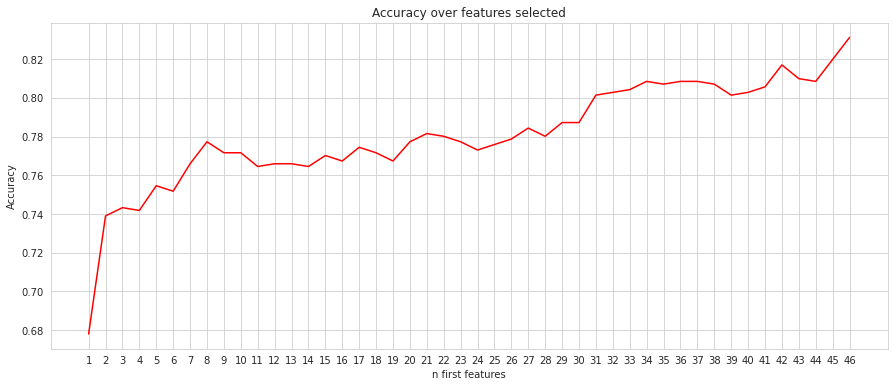

In [75]:
feature_len = input_size
scores = []
#  Add features one by one to observe the loss
for n in range(1, feature_len + 1):
    selected_features = [1] * n + [0] * (feature_len - n)
    selected_features = torch.tensor(selected_features).to(util.device)
    score = feedback(selected_features)
    print(f"{n} feature. score = {score}")
    scores.append(score)
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 6)) 
plt.plot([i + 1 for i in range(feature_len)], scores, color='red')
plt.xticks(numpy.arange(1, feature_len + 1, 1.0))
plt.xlabel('n first features')
plt.ylabel('Accuracy')
plt.title('Accuracy over features selected')
plt.show()

Select features by utilizing genetic algorithm:

gen	nevals	min     	avg     
0  	30    	0.746099	0.793901
1  	20    	0.765957	0.80156 
2  	21    	0.785816	0.810638
3  	22    	0.788652	0.815035
4  	26    	0.808511	0.820284
5  	21    	0.8     	0.821087
6  	18    	0.805674	0.823499
7  	22    	0.807092	0.825957
8  	23    	0.815603	0.827234
9  	26    	0.801418	0.827139
10 	23    	0.804255	0.829787
11 	17    	0.817021	0.829929
12 	19    	0.821277	0.832199
13 	19    	0.805674	0.830827
14 	20    	0.805674	0.831348
15 	21    	0.817021	0.832624
16 	21    	0.805674	0.833617
17 	20    	0.819858	0.835272
18 	18    	0.81844 	0.835745
19 	25    	0.807092	0.833522
20 	21    	0.814184	0.835697
21 	26    	0.807092	0.834941
22 	19    	0.817021	0.836643
23 	24    	0.805674	0.836454
24 	17    	0.822695	0.838818
25 	25    	0.828369	0.839858
	Selected feature= [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]
	Accuracy =0.8411347517730496


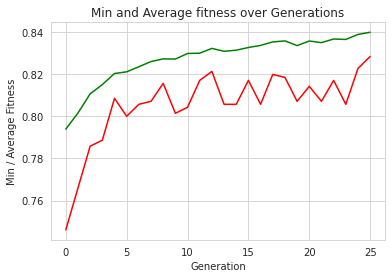

In [30]:
def test_score(selected_features):
    selected_features = torch.tensor(selected_features).to(util.device)
    return feedback(selected_features),

NUM_OF_FEATURES = input_size


POPULATION_SIZE = 30
P_CROSSOVER = 0.7
P_MUTATION = 0.3
MAX_GENERATIONS = 25
HALL_OF_FAME_SIZE = 3

toolbox = base.Toolbox()

# Trying to maximize the accuracy; that's why 1
creator.create("fitness_min", base.Fitness, weights=(1.0,))

creator.create("individual", list, fitness=creator.fitness_min)
toolbox.register("zero_or_one", random.randint, 0, 1)
toolbox.register("individual_creator", tools.initRepeat, creator.individual, toolbox.zero_or_one, NUM_OF_FEATURES)
toolbox.register("population_creator", tools.initRepeat, list, toolbox.individual_creator)

toolbox.register("evaluate", test_score)

# Genetic operators for binary data
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/NUM_OF_FEATURES)

def search():
    population = toolbox.population_creator(n=POPULATION_SIZE)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", numpy.min)
    stats.register("avg", numpy.mean)

    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                      ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)
    best = hof.items[0]
    print('\tSelected feature=', best)
    print(f'\tAccuracy ={best.fitness.values[0]}')

    min_fit, mean_fit = logbook.select('min', 'avg')

    # Plotting
    sns.set_style('whitegrid')
    plt.plot(min_fit, color='red')
    plt.plot(mean_fit, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')
    plt.show()

search()

Redundant features:

In [64]:
chosen_features = [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]
zero_indices = [i for i, n in enumerate(chosen_features) if n == 0]
# Redundant columns
list(data.columns[zero_indices])

['PaymentMethod_bank_transfer_(automatic)',
 'PaymentMethod_credit_card_(automatic)',
 'StreamingMovies_yes',
 'StreamingTV_no',
 'StreamingTV_yes',
 'TechSupport_no',
 'TechSupport_no_internet_service',
 'OnlineBackup_no',
 'OnlineBackup_no_internet_service',
 'OnlineSecurity_no_internet_service',
 'OnlineSecurity_yes',
 'InternetService_dsl',
 'PhoneService_yes',
 'Dependents_yes',
 'gender_female']